In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from phase_2.scripts.strategies.trend.trend_strategy_v1 import run_trend_strategy_v1
from phase_2.scripts.strategies.meanrev.meanrev_strategy_v1 import run_meanrev_strategy_v1
from phase_2.scripts.strategies.meta.meta_allocator_v1 import build_regime_features, build_meta_raw_returns
from phase_2.scripts.strategies.meta.risk_targeting_v1 import apply_vol_targeting

from phase_2.scripts.strategies.portfolio.portfolio_constructor_v1 import (
    align_asset_returns,
    compute_inverse_vol_weights,
    build_portfolio_raw_returns,
)


In [18]:
ASSETS = ["SPY", "AAPL", "MSFT"]

data = {}
for sym in ASSETS:
    df = pd.read_parquet(f"../data/processed/{sym.lower()}_daily.parquet")
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)
    df["year"] = df["date"].dt.year
    data[sym] = df

years = sorted(data["SPY"]["year"].unique())


In [19]:
asset_daily_all = []
portfolio_daily_all = []

for test_year in years:
    asset_daily = {}

    # -------------------------------
    # 1. Build per-asset meta_raw_ret streams for this year
    # -------------------------------
    for sym, df in data.items():
        train = df[df["year"] < test_year].copy()
        test  = df[df["year"] == test_year].copy()

        if len(train) < 500 or len(test) < 60:
            continue

        trend_out = run_trend_strategy_v1(test, train_df=train)
        meanrev_out = run_meanrev_strategy_v1(test)

        regime = build_regime_features(test)
        meta = build_meta_raw_returns(trend_out, meanrev_out, regime)

        # asset-level vol targeting (optional but useful for diagnostics)
        # We are not using asset-level vol-targeted returns to construct the portfolio, we are only using them as a diagnostic lens
        # It allows inspection of how individual assets and strategies behave under risk normalization without influencing portfolio construction
        vt_asset = apply_vol_targeting(meta["meta_raw_ret"], target_vol_annual=0.10, lookback=20, max_leverage=1.0)
        meta["lev"] = vt_asset["lev"]
        meta["meta_ret"] = vt_asset["meta_ret"]

        meta["asset"] = sym
        meta["year"] = test_year

        asset_daily[sym] = meta

    if len(asset_daily) != len(ASSETS):
        continue

    # -------------------------------
    # 2. Portfolio construction based on meta_raw_ret
    # - meta df includes both meta_ret (vol targeted per asset) and meta_raw_ret (not vol targeted)
    # - Here we use the meta_raw_ret for portfolio construction
    # -------------------------------
    ret_wide = align_asset_returns(asset_daily)
    w = compute_inverse_vol_weights(ret_wide, lookback=20, max_weight=0.70)
    port_raw = build_portfolio_raw_returns(ret_wide, w)

    # portfolio-level vol targeting
    vt_port = apply_vol_targeting(port_raw, target_vol_annual=0.10, lookback=20, max_leverage=1.0)

    port = pd.DataFrame({
        "date": port_raw.index,
        "portfolio_raw_ret": port_raw.values,
        "portfolio_lev": vt_port["lev"].values,
        "portfolio_ret": vt_port["meta_ret"].values,
        "year": test_year,
    })

    portfolio_daily_all.append(port)

    # stack asset daily
    asset_daily_all.append(pd.concat(asset_daily.values(), ignore_index=True))

asset_daily_all = pd.concat(asset_daily_all).sort_values(["date", "asset"]).reset_index(drop=True)
portfolio_daily = pd.concat(portfolio_daily_all).sort_values("date").reset_index(drop=True)

asset_daily_all.head(), portfolio_daily.head()


(        date state  meta_raw_ret  lev  meta_ret asset  year
 0 2012-01-03  CASH           0.0  0.0       0.0  AAPL  2012
 1 2012-01-03  CASH           0.0  0.0       0.0  MSFT  2012
 2 2012-01-03  CASH           0.0  0.0       0.0   SPY  2012
 3 2012-01-04  CASH           0.0  0.0       0.0  AAPL  2012
 4 2012-01-04  CASH           0.0  0.0       0.0  MSFT  2012,
         date  portfolio_raw_ret  portfolio_lev  portfolio_ret  year
 0 2012-01-03                0.0            0.0            0.0  2012
 1 2012-01-04                0.0            0.0            0.0  2012
 2 2012-01-05                0.0            0.0            0.0  2012
 3 2012-01-06                0.0            0.0            0.0  2012
 4 2012-01-09                0.0            0.0            0.0  2012)

In [20]:
def compute_equity_curve(daily_ret: pd.Series) -> pd.Series:
    return (1 + daily_ret.fillna(0.0)).cumprod()

def compute_drawdown(equity: pd.Series) -> pd.Series:
    peak = equity.cummax()
    return equity / peak - 1.0

def find_top_drawdowns(df: pd.DataFrame, ret_col: str, top_n: int = 5, min_gap_days: int = 60) -> pd.DataFrame:
    """
    Find top N drawdown troughs and approximate drawdown windows.
    We enforce spacing between selected troughs so we don't pick the same episode repeatedly.
    """
    tmp = df.copy()
    tmp = tmp.sort_values("date").reset_index(drop=True)

    equity = compute_equity_curve(tmp[ret_col])
    dd = compute_drawdown(equity)

    tmp["equity"] = equity.values
    tmp["drawdown"] = dd.values

    # candidates sorted by worst drawdown first (most negative)
    candidates = tmp.sort_values("drawdown").reset_index(drop=True)

    chosen = []
    chosen_dates = []

    for _, row in candidates.iterrows():
        trough_date = row["date"]

        # enforce spacing between troughs
        if any(abs((trough_date - d).days) < min_gap_days for d in chosen_dates):
            continue

        # find peak before trough (start)
        trough_idx = tmp.index[tmp["date"] == trough_date][0]
        start_idx = tmp.loc[:trough_idx, "equity"].idxmax()
        start_date = tmp.loc[start_idx, "date"]

        # find recovery after trough (end): first date equity >= prior peak
        peak_equity = tmp.loc[start_idx, "equity"]
        post = tmp.loc[trough_idx:]
        rec = post[post["equity"] >= peak_equity]
        end_date = rec["date"].iloc[0] if len(rec) > 0 else tmp["date"].iloc[-1]

        chosen.append({
            "start_date": start_date,
            "trough_date": trough_date,
            "end_date": end_date,
            "max_drawdown": row["drawdown"],
        })
        chosen_dates.append(trough_date)

        if len(chosen) >= top_n:
            break

    return pd.DataFrame(chosen).sort_values("max_drawdown")


In [21]:
portfolio_daily["date"] = pd.to_datetime(portfolio_daily["date"])

dd_table = find_top_drawdowns(portfolio_daily, ret_col="portfolio_ret", top_n=5, min_gap_days=90)
dd_table


,start_date,trough_date,end_date,max_drawdown
0,2014-11-26,2015-08-25,2015-10-29,-0.083886
1,2022-08-15,2022-09-30,2023-05-26,-0.082459
2,2024-12-17,2025-04-29,2025-07-03,-0.080150
3,2012-04-02,2012-05-18,2012-09-06,-0.074654
4,2018-10-03,2018-12-24,2019-04-23,-0.071035


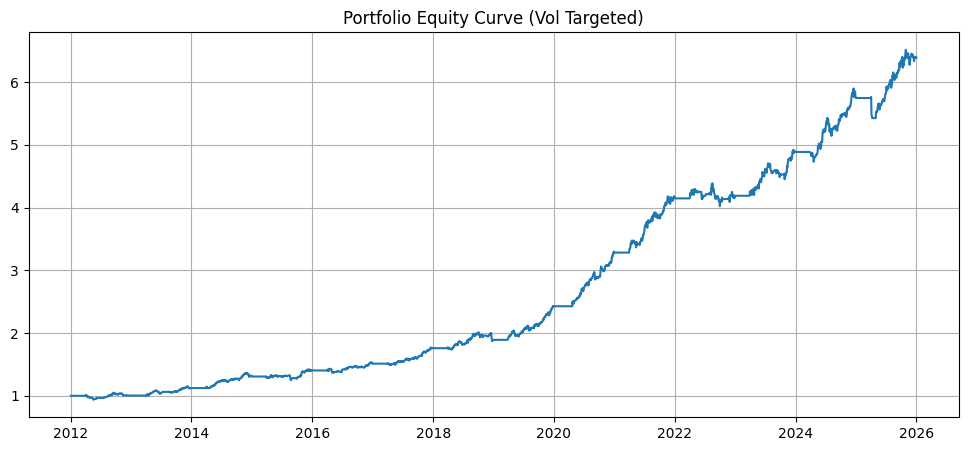

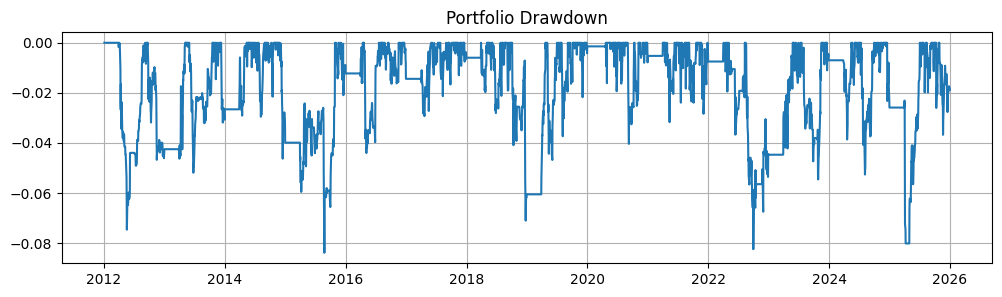

In [22]:
equity = compute_equity_curve(portfolio_daily["portfolio_ret"])
dd = compute_drawdown(equity)

plt.figure(figsize=(12,5))
plt.plot(portfolio_daily["date"], equity)
plt.title("Portfolio Equity Curve (Vol Targeted)")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,3))
plt.plot(portfolio_daily["date"], dd)
plt.title("Portfolio Drawdown")
plt.grid(True)
plt.show()



=== Drawdown #1 ===
Start:  2014-11-26 | Trough: 2015-08-25 | End: 2015-10-29 | MaxDD: -8.39%


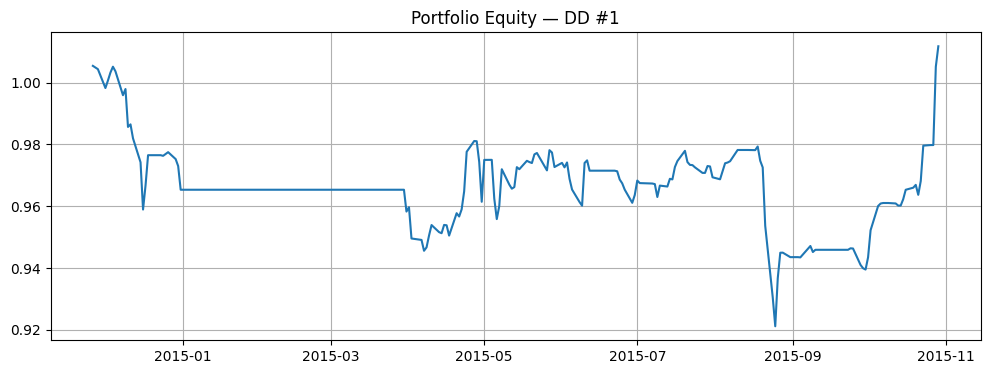

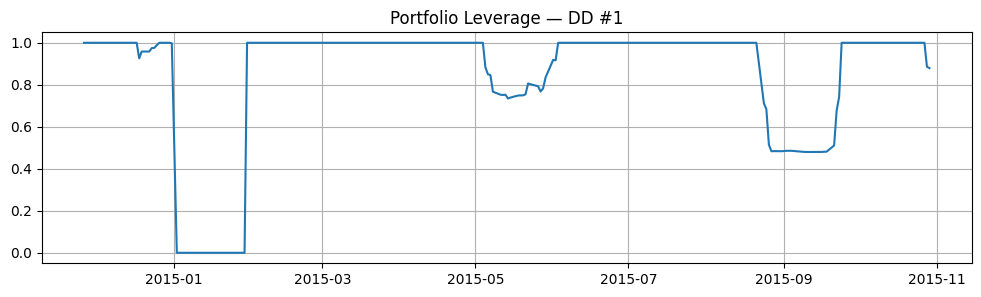

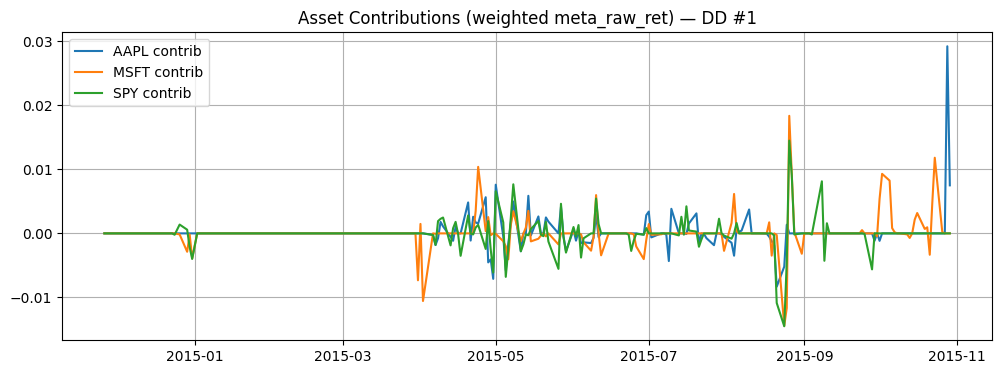

asset  asset  state  
AAPL   AAPL   CASH       0.493562
              MEANREV    0.253219
              TREND      0.253219
MSFT   MSFT   CASH       0.502146
              MEANREV    0.193133
              TREND      0.304721
SPY    SPY    CASH       0.497854
              MEANREV    0.124464
              TREND      0.377682
Name: frac, dtype: float64


=== Drawdown #2 ===
Start:  2022-08-15 | Trough: 2022-09-30 | End: 2023-05-26 | MaxDD: -8.25%


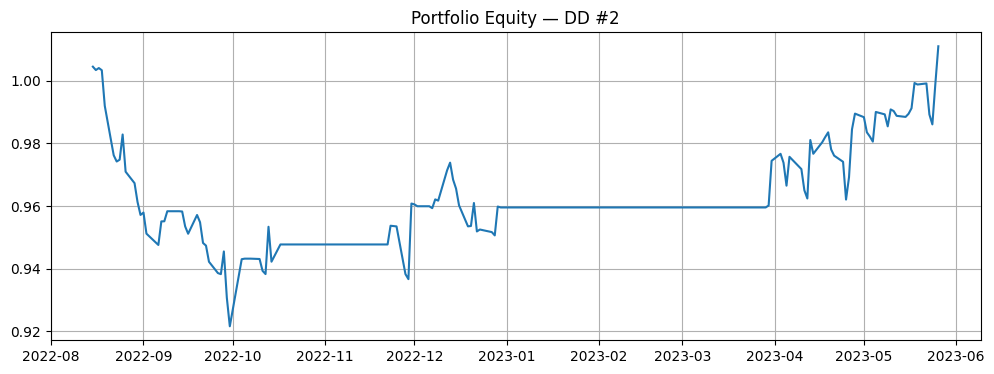

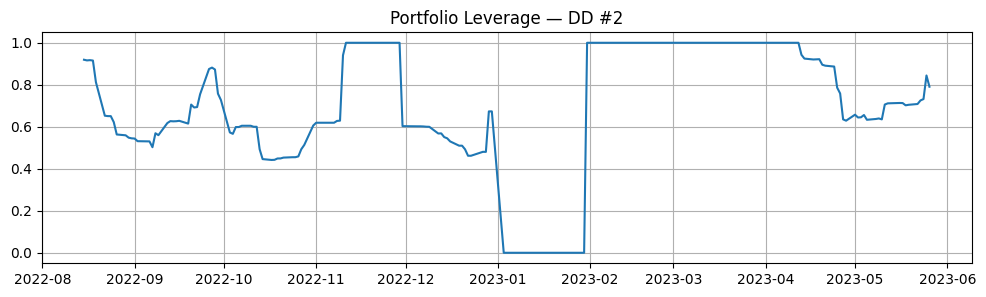

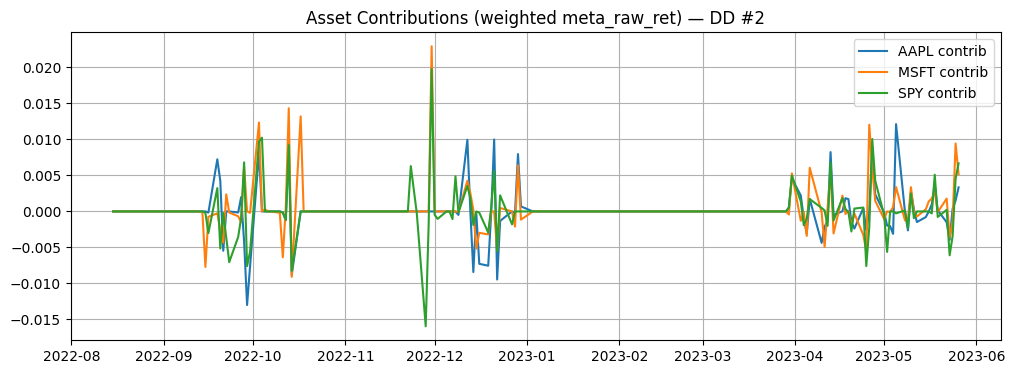

asset  asset  state  
AAPL   AAPL   CASH       0.494949
              MEANREV    0.237374
              TREND      0.267677
MSFT   MSFT   CASH       0.489899
              MEANREV    0.207071
              TREND      0.303030
SPY    SPY    CASH       0.459596
              MEANREV    0.237374
              TREND      0.303030
Name: frac, dtype: float64


=== Drawdown #3 ===
Start:  2024-12-17 | Trough: 2025-04-29 | End: 2025-07-03 | MaxDD: -8.01%


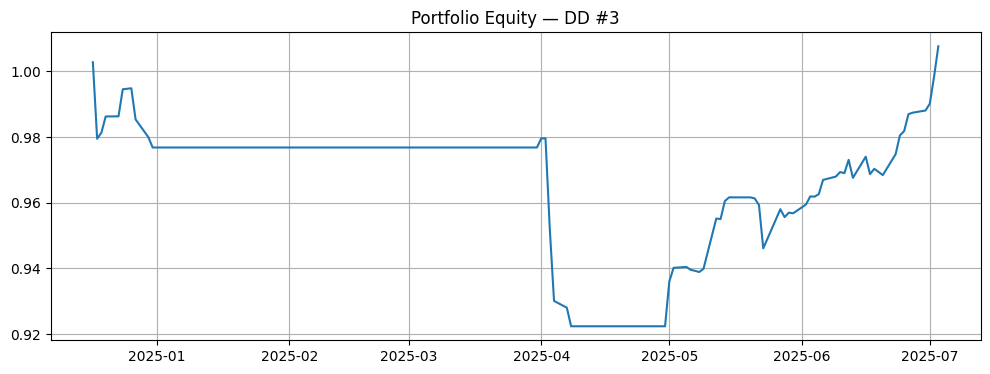

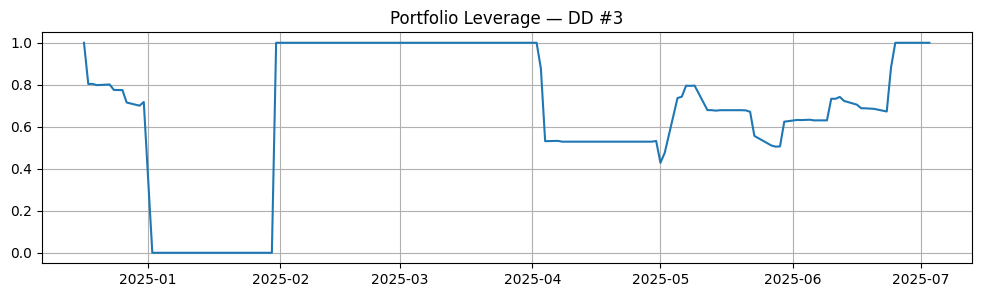

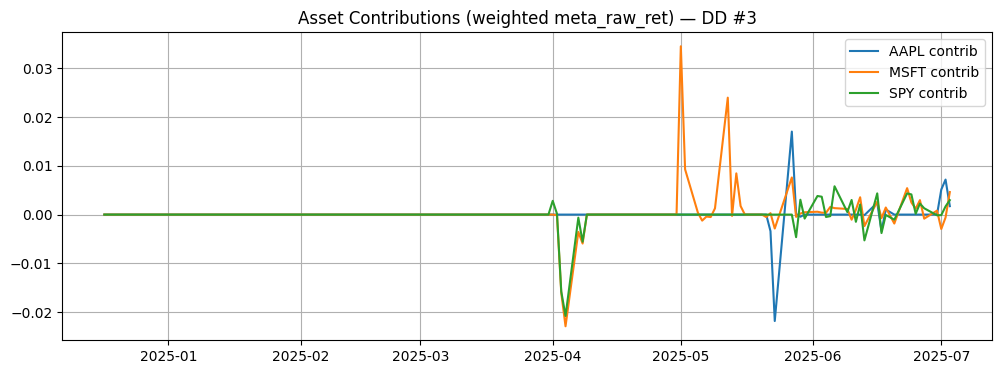

asset  asset  state  
AAPL   AAPL   CASH       0.792593
              MEANREV    0.111111
              TREND      0.096296
MSFT   MSFT   CASH       0.562963
              MEANREV    0.044444
              TREND      0.392593
SPY    SPY    CASH       0.696296
              MEANREV    0.051852
              TREND      0.251852
Name: frac, dtype: float64


=== Drawdown #4 ===
Start:  2012-04-02 | Trough: 2012-05-18 | End: 2012-09-06 | MaxDD: -7.47%


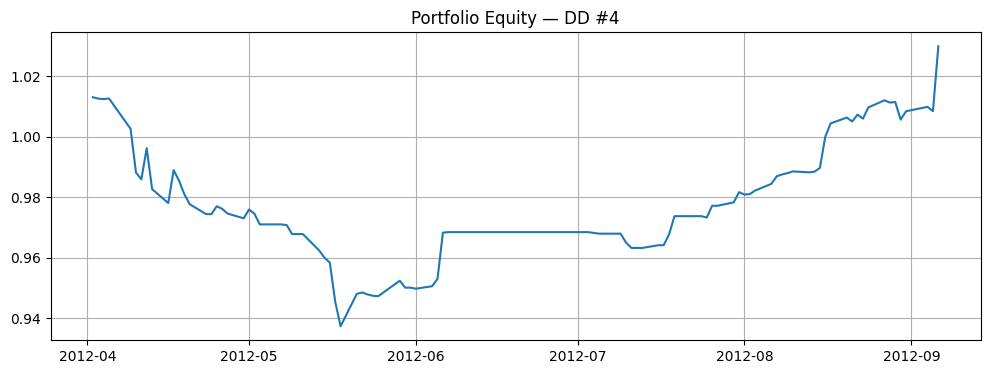

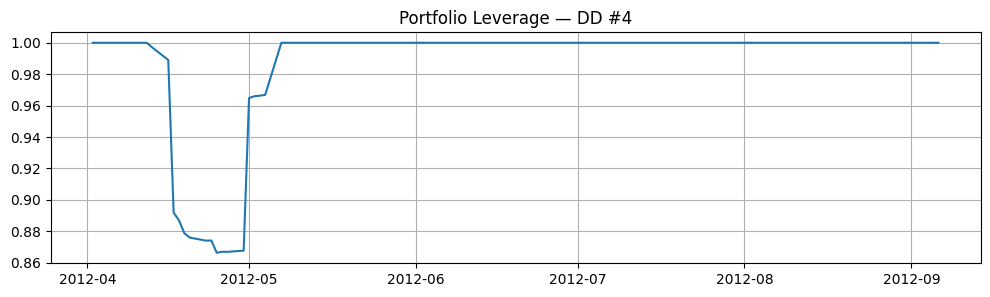

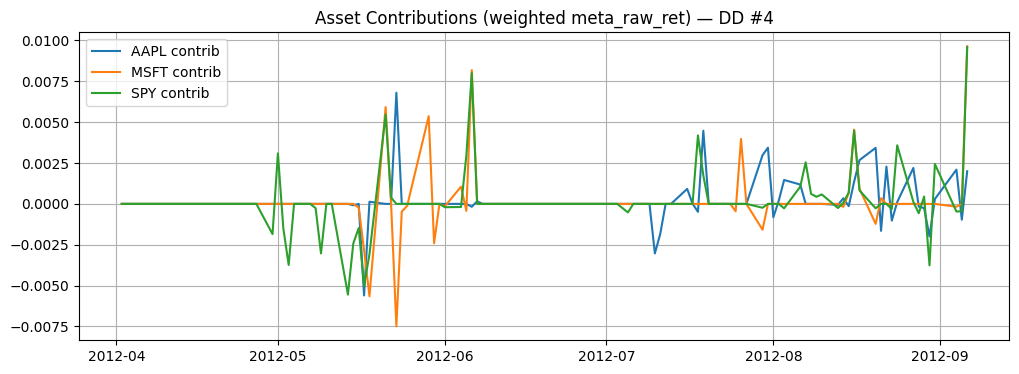

asset  asset  state  
AAPL   AAPL   CASH       0.418182
              MEANREV    0.109091
              TREND      0.472727
MSFT   MSFT   CASH       0.318182
              MEANREV    0.345455
              TREND      0.336364
SPY    SPY    CASH       0.345455
              MEANREV    0.218182
              TREND      0.436364
Name: frac, dtype: float64


=== Drawdown #5 ===
Start:  2018-10-03 | Trough: 2018-12-24 | End: 2019-04-23 | MaxDD: -7.10%


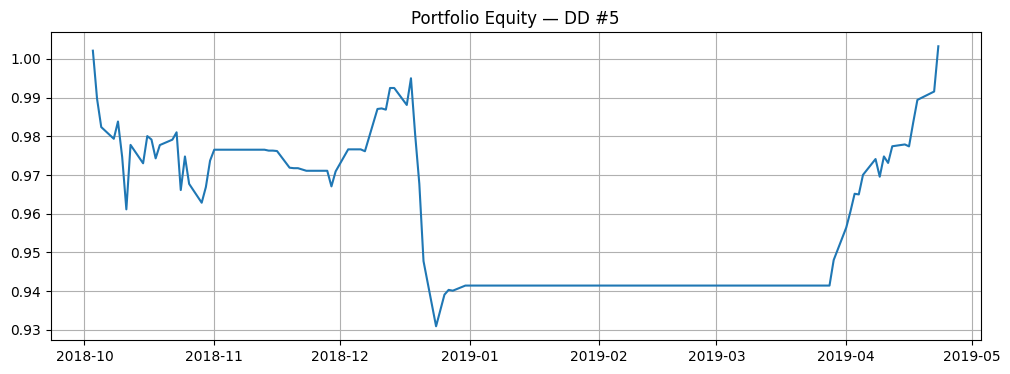

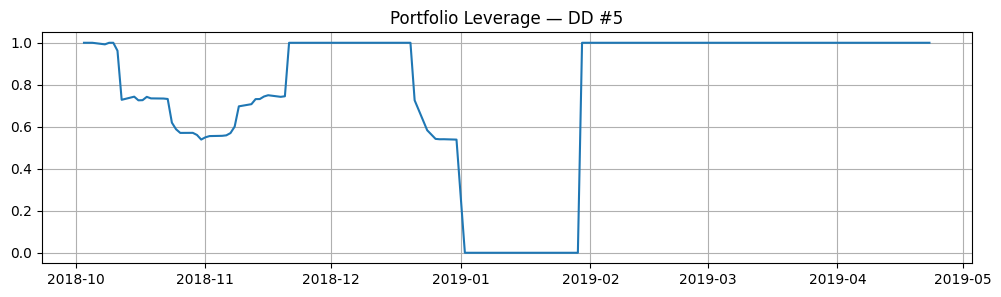

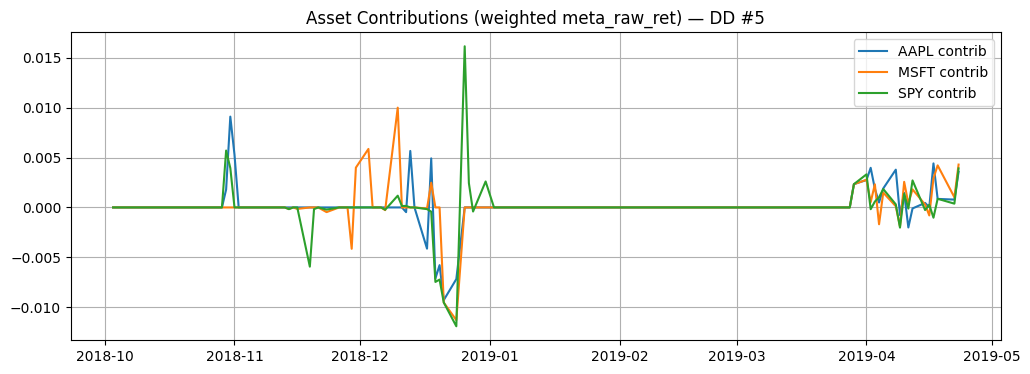

asset  asset  state  
AAPL   AAPL   CASH       0.659420
              MEANREV    0.130435
              TREND      0.210145
MSFT   MSFT   CASH       0.644928
              MEANREV    0.130435
              TREND      0.224638
SPY    SPY    CASH       0.543478
              MEANREV    0.297101
              TREND      0.159420
Name: frac, dtype: float64

In [23]:
def slice_window(df: pd.DataFrame, start, end):
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    return df[(df["date"] >= start) & (df["date"] <= end)].copy()

for i, row in dd_table.reset_index(drop=True).iterrows():
    start, trough, end = row["start_date"], row["trough_date"], row["end_date"]

    port_win = slice_window(portfolio_daily, start, end)
    eq_win = compute_equity_curve(port_win["portfolio_ret"])

    print(f"\n=== Drawdown #{i+1} ===")
    print(f"Start:  {start.date()} | Trough: {trough.date()} | End: {end.date()} | MaxDD: {row['max_drawdown']:.2%}")

    # 1) Portfolio equity in window
    plt.figure(figsize=(12,4))
    plt.plot(port_win["date"], eq_win)
    plt.title(f"Portfolio Equity — DD #{i+1}")
    plt.grid(True)
    plt.show()

    # 2) Portfolio leverage in window
    plt.figure(figsize=(12,3))
    plt.plot(port_win["date"], port_win["portfolio_lev"])
    plt.title(f"Portfolio Leverage — DD #{i+1}")
    plt.grid(True)
    plt.show()

    # 3) Asset contributions (approx)
    # We recompute weights + contributions in this window from asset meta_raw_ret
    asset_win = slice_window(asset_daily_all, start, end)
    # pivot meta_raw_ret wide
    asset_pivot = asset_win.pivot(index="date", columns="asset", values="meta_raw_ret").sort_index()
    w_win = compute_inverse_vol_weights(asset_pivot, lookback=20, max_weight=0.70)

    contrib = (w_win * asset_pivot).fillna(0.0)

    plt.figure(figsize=(12,4))
    for col in contrib.columns:
        plt.plot(contrib.index, contrib[col], label=f"{col} contrib")
    plt.title(f"Asset Contributions (weighted meta_raw_ret) — DD #{i+1}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 4) State mix per asset during window
    state_mix = (
        asset_win.groupby(["asset", "state"])
        .size()
        .groupby(level=0)
        .apply(lambda x: x / x.sum())
        .rename("frac")
    )
    display(state_mix)
